In [2]:
!pip install -U d2l
!python -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple

     |████████████████████████████████| 82 kB 182 kB/s 
Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 108.9 MB 22 kB/s 


# 3.2 线性回归从0开始实现

In [3]:
import random
# torch
import torch
from d2l import torch as d2l
# paddle
import numpy as np
import paddle
import matplotlib.pyplot as plt

## 3.2.1生成数据集

这里根据带有噪声的线性模型构造一个人造数据集。然后使用这个有限样本的数据集恢复此模型的参数。为了方便可视化，这里采用了低维数据。

下面代码中，生成了一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的两个特征。合成数据集是一个矩阵：

$$X\in R^{100 \times 2}$$

使用线性模型参数$w=[2,-3.4]^T$、$b=4.2$和噪声项$\varepsilon$生成数据集及其标签：
$$y=Xw+b+\varepsilon$$

你可以将$\varepsilon$视为捕获特征和标签时的潜在观测误差。在这里我们认为标准假设成立，即$\varepsilon$服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。

#### torch版

In [4]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.6691, -0.2756]) 
label: tensor([6.4794])


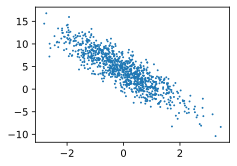

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

#### paddle版

In [6]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle works well on 2 CPUs.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


In [25]:
def synthetic_data_paddle(w, b, num_examples):
  """Generate y = Xw + b + noise."""
  X = np.random.normal(0, 1, (num_examples, len(w)))
  y = np.dot(X, w) + b
  y += np.random.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

paddle_w = np.array([2, -3.4])
paddle_b = 4.2
paddle_features, paddle_labels = synthetic_data_paddle(paddle_w, paddle_b, 1000)
print('paddle features:', paddle_features[0], '\nlabel:', paddle_labels[0])

paddle features: [0.87615536 0.1851289 ] 
label: [5.30901931]


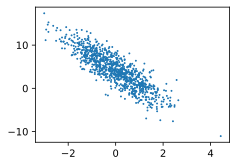

In [8]:
plt.scatter(paddle_features[:, (1)], paddle_labels, 1);

## 3.2.2 读取数据集

训练模型时要对数据遍历，每次抽取一小批量样本，并使用它们来更新模型。由于此过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能够打乱数据集中的样本并以小批量的方式获取数据。

在下面代码中，定义了一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量，每个小批量包含一组特征和标签。

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

通常，我们使用合理大小的小批量来利用GPU硬件的优势，因为GPU在并行处理方面表现出色。每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行地计算，GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

让我们直观感受一下。读取第一个小批量数据样本并打印。每个批量的特征维度说明了批量大小和输入特征数。 同样的，批量的标签形状与`batch_size`相等。

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7002,  0.4918],
        [-0.9481, -0.8751],
        [-1.9653, -2.5903],
        [-0.1594, -0.8751],
        [-0.1949,  0.1681],
        [ 1.0489,  0.8604],
        [-2.3937,  0.9662],
        [ 0.8804,  0.2414],
        [ 1.4275, -0.6885],
        [ 0.8995,  0.7009]]) 
 tensor([[ 3.9149],
        [ 5.2895],
        [ 9.0836],
        [ 6.8627],
        [ 3.2225],
        [ 3.3785],
        [-3.8819],
        [ 5.1302],
        [ 9.4061],
        [ 3.6104]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和通过数据流提供的数据。

## 3.2.3 初始化模型参数

在开始用小批量随机梯度下降优化模型参数之前，我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

#### torch版

In [11]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w)
print(b)

tensor([[0.0176],
        [0.0289]], requires_grad=True)
tensor([0.], requires_grad=True)


#### paddle版

In [21]:
# paddle_w = paddle.nn.initializer.Normal(0, 0.01)
# paddle_w.stop_gradient = False
# paddle_b = paddle.zeros(shape=[1])
# paddle_b.stop_gradient = False
paddle_w = np.random.normal(0, 0.01, (2, 1))
paddle_b = np.zeros(1)
print(paddle_w)
print(paddle_b)

[[0.00343449]
 [0.01002069]]
[0.]


在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。 因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。我们使用 2.5节 中引入的自动微分来计算梯度。

## 3.2.4 定义模型
接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。 回想一下，要计算线性模型的输出，我们只需计算输入特征  𝐗  和模型权重 𝐰 的矩阵-向量乘法后加上偏置 𝑏 。注意，上面的 𝐗𝐰  是一个向量，而 𝑏 是一个标量。回想一下 2.1.3节 中描述的广播机制。当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

#### torch版

In [13]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

#### paddle版

In [23]:
def paddle_linreg(X, w, b):
    """线性回归模型。"""
    # return paddle.matmul(X, w) + b
    return np.dot(X, w) + b

## 3.2.5 定义损失函数
因为要更新模型。需要计算损失函数的梯度，所以我们应该先定义损失函数。 这里我们使用 3.1节 中描述的平方损失函数。 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [15]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 3.2.6 定义优化算法

正如我们在 3.1节 中讨论的，线性回归有解析解。然而，这是一本关于深度学习的书，而不是一本关于线性回归的书。 由于这本书介绍的其他模型都没有解析解，下面我们将在这里介绍小批量随机梯度下降的工作示例。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size）来归一化步长，这样步长大小就不会取决于我们对批量大小的选择。

#### torch版

In [16]:
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### paddle版

In [17]:
def pddle_sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with paddle.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。 理解这段代码至关重要，因为在整个深度学习的职业生涯中，你会一遍又一遍地看到几乎相同的训练过程。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法 sgd 来更新模型参数。

接下来，将执行一下循环：

- 初始化参数
- 重复，直到完成
  - 计算梯度 $g \leftarrow \partial_{(w,b)}\frac{1}{\vert B\vert}\sum_{i \in B}l(x^{(i)},y^{(i)},w,b)$
  - 更新参数$(w,b) \leftarrow (w,b) \leftarrow \eta g$ 

在每个迭代周期（epoch）中，我们使用`data_iter`函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。 我们现在忽略这些细节，以后会在 2节 中详细介绍。

#### torch版

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030590
epoch 2, loss 0.000109
epoch 3, loss 0.000052


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。事实上，真实参数和通过训练学到的参数确实非常接近。

In [19]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0002, 0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地恢复参数。 在机器学习中，我们通常不太关心恢复真正的参数，而更关心那些能高度准确预测的参数。 幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

#### paddle版

In [26]:
lr = 0.03
num_epochs = 3
net = paddle_linreg
loss = squared_loss

for epoch in range(num_epochs):
    for paddle_X, paddle_y in data_iter(batch_size, features, labels):
        l = loss(net(paddle_X, paddle_w, paddle_b), paddle_y)  # `paddle_X`和`paddle_y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`paddle_w`, `paddle_b`]的梯度
        l.sum().backward()
        paddle_sgd([paddle_w, paddle_b], lr, batch_size)  # 使用参数的梯度更新参数
    with paddle.no_grad():
        paddle_train_l = loss(net(paddle_features, paddle_w, paddle_b), padle_labels)
        print(f'epoch {epoch + 1}, loss {float(pddle_train_l.mean()):f}')

TypeError: ignored